<a href="https://colab.research.google.com/github/mikolaj553/Machine-Learning-Homeworks-Repo/blob/main/ml_hw4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Homework #4 - Mikołaj Kowalewski, lab group no. 1**

Let us start off with generating a synthetic dataset from a known sparse linear model and examine how varying the regularization parameter $\lambda$ impacts the squared bias, variance, and mean squared error (MSE).

The true model is given by:
$$
y = \beta_0 + \sum_{j=1}^{50} \beta_j x_j + \varepsilon,
$$
with $$
\varepsilon \sim \mathcal{N}(0, \sigma^2)
$$
 Only the first 5 coefficients are nonzero:
$$
\beta = [3.0,\ 2.0,\ 1.5,\ 1.0,\ 0.5,\ 0,\dots,0].
$$

We will simulate multiple training sets, fit both Ridge and Lasso models for a range of $λ$ values, and for each value estimate:
- **Squared Bias**:
  $$
  \text{Bias}^2 =(\mathbb{E}[\hat{f}(x)] - f(x))^2
  $$
- **Variance**:
  $$
  \mathbb{E}\!\left[\left(\hat{f}(x)-\mathbb{E}[\hat{f}(x)]\right)^2\right]
  $$
- **MSE**:
  $$
  \text{Bias}^2 + \text{Variance}
  $$


These components together with the irreducible error $σ^2$ (noise) yield the total prediction error.



In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge, Lasso
from tqdm import tqdm

# For reproducibility
np.random.seed(42)

# Plotting
sns.set(style='whitegrid')


The methodology of our experiments is as follows:
1. We generate many different training sets by simulating them from the same data distribution.
2. Train the model separately on each training set.
3. Use all the resulting models to make predictions on a fixed test set.
4. At each test point:
   - Compute the mean prediction across all models → this gives an estimate of the average model.
   - Compute the variance of predictions around that mean → this estimates model variance.
   - Compare the mean prediction to the true target and square the result → this estimates bias².

The parameters for the simulations are as follows:

- **Number of predictors (p):** 50  
- **Non-zero coefficients:** First 5 elements are nonzero: $[3.0, 2.0, 1.5, 1.0, 0.5]$
- **Training sample size (n_train):** 100  
- **Test sample size (n_test):** 500  
- **Noise standard deviation:** 3 (so variance equals 9)  
- **Number of Monte Carlo replications:** 200  
- **Regularization parameter (λ) grid:** 100 logarithmically spaced values from $10^{-2}$ to $1000$


In [27]:
# Simulation parameters
p = 50
n_train = 100
n_test = 500
sigma = 3.0
n_reps = 200
lambdas = np.logspace(-2, 3, 100)

# True coefficients: first 5 are nonzero, the rest are 0.
beta_true = np.zeros(p)
beta_true[:5] = np.array([3.0, 2.0, 1.5, 1.0, 0.5])

# Generating a fixed test set (X_test) and computing the true function values f(x)
X_test = np.random.randn(n_test, p)
f_test = X_test @ beta_true

print("Test set generated: X_test.shape =", X_test.shape)


Test set generated: X_test.shape = (500, 50)


In [28]:
# Initializing arrays to store results for each lambda
ridge_bias2 = np.zeros(len(lambdas))
ridge_variance = np.zeros(len(lambdas))
ridge_mse = np.zeros(len(lambdas))

lasso_bias2 = np.zeros(len(lambdas))
lasso_variance = np.zeros(len(lambdas))
lasso_mse = np.zeros(len(lambdas))

# Looping over lambda values
for i, lam in enumerate(tqdm(lambdas, desc="Processing λ values")):

    # Storing predictions for current lambda (each: shape [n_reps, n_test])
    ridge_preds = np.zeros((n_reps, n_test))
    lasso_preds = np.zeros((n_reps, n_test))

    for rep in range(n_reps):
        # Generating training data
        X_train = np.random.randn(n_train, p)
        noise = sigma * np.random.randn(n_train)
        y_train = X_train @ beta_true + noise

        # Ridge Regression
        ridge_model = Ridge(alpha=lam, fit_intercept=False)
        ridge_model.fit(X_train, y_train)
        ridge_preds[rep] = ridge_model.predict(X_test)

        # Lasso Regression
        lasso_model = Lasso(alpha=lam, fit_intercept=False, max_iter=10000)
        lasso_model.fit(X_train, y_train)
        lasso_preds[rep] = lasso_model.predict(X_test)

    # Computing bias^2 and variance across the test set for Ridge
    ridge_mean_preds = np.mean(ridge_preds, axis=0)  # Averaging prediction for each test point
    ridge_bias2[i] = np.mean((ridge_mean_preds - f_test)**2)
    ridge_variance[i] = np.mean(np.var(ridge_preds, axis=0, ddof=1))
    ridge_mse[i] = ridge_bias2[i] + ridge_variance[i]

    # Computing bias^2 and variance for Lasso
    lasso_mean_preds = np.mean(lasso_preds, axis=0)
    lasso_bias2[i] = np.mean((lasso_mean_preds - f_test)**2)
    lasso_variance[i] = np.mean(np.var(lasso_preds, axis=0, ddof=1))
    lasso_mse[i] = lasso_bias2[i] + lasso_variance[i]

print("Simulation complete.")


Processing λ values: 100%|██████████| 100/100 [00:46<00:00,  2.15it/s]

Simulation complete.


In [31]:
# Finding trade-off points: λ that minimizes MSE
ridge_opt_idx = np.argmin(ridge_mse)
ridge_opt_lambda = lambdas[ridge_opt_idx]

lasso_opt_idx = np.argmin(lasso_mse)
lasso_opt_lambda = lambdas[lasso_opt_idx]

print(f"Optimal λ for Ridge: {ridge_opt_lambda:.4f}")
print(f"Optimal λ for Lasso: {lasso_opt_lambda:.4f}")


Optimal λ for Ridge: 34.3047
Optimal λ for Lasso: 0.3275


Let us know plot the results of the experiments.

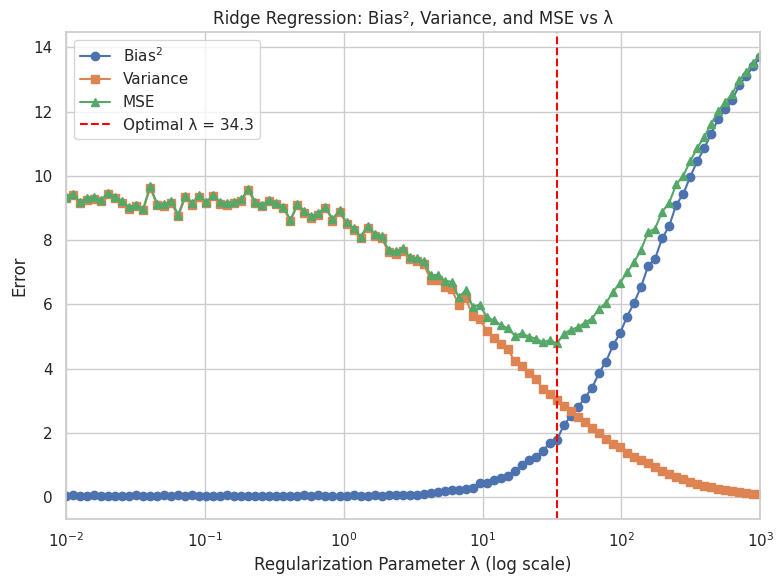

In [34]:
# Plotting Ridge results
plt.figure(figsize=(8,6))
plt.plot(lambdas, ridge_bias2, label='Bias$^2$', marker='o')
plt.plot(lambdas, ridge_variance, label='Variance', marker='s')
plt.plot(lambdas, ridge_mse, label='MSE', marker='^')
plt.axvline(ridge_opt_lambda, color='red', linestyle='--', label=f'Optimal λ = {ridge_opt_lambda:.3g}')
plt.xscale('log')
plt.xlim(1e-2, 1e3)
plt.xlabel('Regularization Parameter λ (log scale)')
plt.ylabel('Error')
plt.title('Ridge Regression: Bias², Variance, and MSE vs λ')
plt.legend()
plt.tight_layout()
plt.show()

We can clearly see that the results are as expected - as λ increases, bias increases, variance decreases, and MSE forms a U-shaped curve, revealing the optimal bias-variance trade-off point. Let us now investigate the Lasso results.

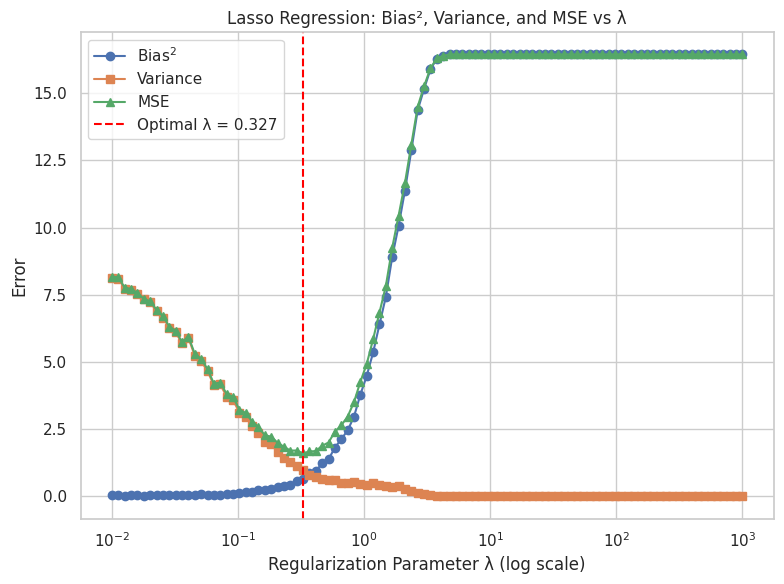

In [35]:
# Plotting Lasso results
plt.figure(figsize=(8,6))
plt.plot(lambdas, lasso_bias2, label='Bias$^2$', marker='o')
plt.plot(lambdas, lasso_variance, label='Variance', marker='s')
plt.plot(lambdas, lasso_mse, label='MSE', marker='^')
plt.axvline(lasso_opt_lambda, color='red', linestyle='--', label=f'Optimal λ = {lasso_opt_lambda:.3g}')
plt.xscale('log')
plt.xlabel('Regularization Parameter λ (log scale)')
plt.ylabel('Error')
plt.title('Lasso Regression: Bias², Variance, and MSE vs λ')
plt.legend()
plt.tight_layout()
plt.show()


Similarly to Ridge, as λ increases, variance decreases and squared bias increases, although the optimal λ is significantly smaller than in the Ridge case. As in the previous case, the MSE reaches a minimum, forming a U-shaped curve.

In [36]:
ridge_min_mse = np.min(ridge_mse)
lasso_min_mse = np.min(lasso_mse)

print(f"Minimum Ridge MSE: {ridge_min_mse:.4f}")
print(f"Minimum Lasso MSE: {lasso_min_mse:.4f}")


Minimum Ridge MSE: 4.7896
Minimum Lasso MSE: 1.6053


## Discussion

**How does varying the regularization parameter λ
 in Ridge and Lasso regression impact the trade-off between bias and variance?**

 **Answer:**

In both Ridge and Lasso regression, the regularization parameter λ determines the strength of penalization applied to the coefficients and therefore directly impacts the complexity of the model. When λ is small (approaching zero), the estimators resemble the unregularized least squares solution. In this regime, the model is highly flexible and tends to overfit the training data. As a result, the bias is low because the model captures most of the signal, but the variance is high, as small changes in the training data may lead to large changes in the fitted model. This can be observed in both of the above plots.

In turn, as λ increases, the regularization becomes stronger. The fitted model becomes less flexible and more stable across different samples. Consequently, the variance of the predictions decreases. However, this comes at the cost of increased bias: the model underfits the data and may fail to capture important aspects of the signal. Similarly to the previous phenomenon, this can be observed in both of the above plots.

Ridge regression, which uses an $ℓ^{2}$ penalty, shrinks coefficients continuously and uniformly toward zero. Its bias and variance curves vary smoothly as λ increases. Lasso regression, in contrast, employs an $ℓ^{1}$  penalty, which induces sparsity and may set some coefficients exactly to zero. This leads to more abrupt changes in the bias and variance curves, especially when predictors are removed from the model. These steeper (than in the Ridge case) curves can be observed in the Lasso plot.

**Does the regularization lead to an optimal trade-off point where MSE is minimized? Explain why this point exists.**

**Answer:**

Yes, the plots for both Ridge and Lasso regression clearly demonstrate the existence of an optimal trade-off point where the MSE is minimized in our example. This point corresponds to a specific value of the regularization parameter λ, which balances the effects of bias and variance. In both plots, the MSE curve exhibits a characteristic U-shape as a function of λ on a logarithmic scale.

The optimal trade-off point is where the sum of squared bias and variance is minimized. This point is highlighted in the plots with a vertical dashed red line: for Lasso, it occurs at approximately λ = 0.327, and for Ridge, at approximately λ = 34.3. At these values, the total prediction error is minimized, indicating the best generalization performance on unseen data.

The MSE itself can be decomposed in the following way:

$$
\mathbb{E}\left[ \left( \hat{f}(x) - f(x) \right)^2 \right] =
\left( \mathbb{E}[\hat{f}(x)] - f(x) \right)^2 +
\mathbb{E}\left[ \left( \hat{f}(x) - \mathbb{E}[\hat{f}(x)] \right)^2 \right] + \sigma^2,
$$

where the first term is the squared bias, the second is the variance, and the third is the irreducible noise. Random noise aside, we can see than the MSE is the sum of squared bias and variance of the model. Informally speaking, since the MSE "blows up" as λ goes to either 0 or infinity (and with proper continuity assumptions), there must exist a point where it is minimized.

**Differences between Lasso and Ridge**

When the underlying model is sparse, meaning that only a small number of predictors have non-zero coefficients, Lasso often outperforms Ridge. This is because Lasso is capable of selecting a subset of features by setting irrelevant coefficients exactly to zero, which can reduce variance and improve interpretability. In contrast, Ridge tends to retain all predictors and only shrink their magnitude, which can dilute the effect of the relevant ones when many irrelevant features are present.

On the other hand, when multicollinearity is present, that is, when predictors are highly correlated, Ridge generally performs better. It handles collinearity by shrinking the coefficients in a way that distributes weight among correlated variables, leading to more stable predictions. Lasso, in such settings, may behave unpredictably by arbitrarily selecting one variable from a group of correlated predictors while discarding others, which can increase variance and hurt the model's ability to generalize.

In our case, we dealt with sparsity (only 5 out of 50 predictors were non-zero). In result, the minimum MSE achieved by Lasso was significantly lower than that of Ridge, which shows Lasso’s advantage in high-dimensional problems where the true signal is concentrated in a small subset of predictors.



